# Final Notebook
* 2/18 22:47: Sorry it's a little messy! The code is a little bit messy, but every field I initially intended on implementing for the output Dataframe (accessed by SequenceSimilarity.p attribute) has finally been filled out. There are some tasks remaining that come off the top of my head...
    * Implement DWT 

In [1]:
%load_ext line_profiler

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Set, Tuple, Dict, List
from scipy import stats, signal
from scipy.fftpack import fft, fftshift
#import sci-kit learn
import textdistance as td
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

class SeqData:

    CONV = {
        'NUM': [0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5, 5, 6, 6, 6, 7],
        'EIIP' : [0.0946, 0.0516, 0.0548, 0.0373, 0.0057, 0.0, 0.0, 0.0823,\
                 0.0829, 0.0941, 0.0036, 0.0761, 0.0198, 0.005, 0.1263, 0.0058, \
                 0.0371, 0.0242, 0.0959, 0.0829],
        'FNS' : ['Aromatic', 'Aromatic', 'Aromatic', 'Hydrophobic', 'Hydrophobic', \
                'Hydrophobic', 'Hydrophobic', 'Hydrophobic', 'Polar', 'Polar', 'Polar', \
                'Polar', 'Proline', 'Glycine', 'Charge (-)', 'Charge (-)', 'Charge (+)', \
                'Charge (+)', 'Charge (+)', 'Excluded'],
    }
    # @TODO: Import Biopython dicts of matrices, not read from .csvs
    MATR = {
        'PAM30': pd.read_csv('./src_data/pam30.csv', index_col=0).to_dict(),
        'BLOSUM45': pd.read_csv('./src_data/BLOSUM.csv', index_col=0).to_dict(),
    }
    DIST = {
        'jaro_winkler': (lambda p1, p2: td.jaro_winkler.normalized_similarity(p1, p2)),
        'needleman_wunsch': (lambda p1, p2: td.needleman_wunsch.normalized_similarity(p1, p2)),
        'smith_waterman': (lambda p1, p2: td.smith_waterman.normalized_similarity(p1, p2)),
        'levenshtein': (lambda p1, p2: td.levenshtein.normalized_similarity(p1, p2))
    }
    
    def __init__(self, conv=CONV.keys(), matr=MATR.keys(), dist=DIST.keys()):
        
        self.conv = {cnv:self.CONV[cnv] for cnv in self.CONV.keys() if cnv in conv}
        self.matr = {mtr:self.MATR[mtr] for mtr in self.MATR.keys() if mtr in matr}
        self.dist = {dst:self.DIST[dst] for dst in self.DIST.keys() if dst in dist}

In [351]:
'''
Class to calculate several simialrity metrics for an input list of peptides given a sequence string to compare it to.
USAGE: 
1. Create SequenceSimilarityObject({sequence string}, {dictionary of data paths} (to be deprecated soon -- use
   internal class data), {path to peptides csv}, {column title of sequence values of aforementioned peptides csv})
   for any number of sequences you want to be compared to the list of peptides
2. For each object, call object.generate_similarity() to fill out the Dataframe with similarity metrics
3. To whittle down this similarity matrix to list only those peptides with pattern matching of a minimum length
   at a matching index in the rerence peptide (henceforth the binder), call object.get_df_with_binder_subseqs(min_length={#})
@ Author: Chris Pecunies, with help from Savvy Gupta and Aaron Tsang
@ Date: February 12, 2020
'''


class SequenceSimilarity:
    '''
    Class that takes in a path to a list of amino acid sequences as well
    as any number of peptide sequences explicitly that are known to have
    a certain set of properties. Generates metrics for similarity for each
    peptide in path and returns domains AA sequence with high similarity
    '''
    AA = list('FYWAVILMSTNQPGDEKHRC')
    
    def __init__(self, binder: Tuple[str, str],
                 data: SeqData,
                 p_path: str,       
                 aa_col: str,
                 dists: List = [],   #set dists = None for no dists
                 only_match: bool = False,
                 min_length: int = 0): 
        
        # ---- setting data ---------
        self.d = {d: vars(data)[d] for d in list(vars(data).keys())}
        self.conv = list(self.d['conv'].keys())
        self.aa_map = {conv:dict(zip(self.AA, self.d['conv'][conv])) for conv in self.conv}
        self.conv_pep = lambda t, p: [self.aa_map[t][AA] if AA in self.AA else 0 for AA in p]
        self.sim_sum = lambda p1, p2, m: sum([self.d['matr'][m][a1][a2] for a1, a2 in zip(p1, p2)])
        
        self.seq = aa_col
        self.sim_cols = ['PAM30', 'BLOSUM45', 'RRM_SN', 'RRM_Corr']
        if dists is not None:
            self.sim_cols += self.d['dist'].keys() if not dists else dists
        self.conv_cols = [conv+'_Seq' for conv in self.conv]
        self.cols = [aa_col] + self.sim_cols + self.conv_cols
        self.bname, self.b = binder
        self.bsseq = [(self.b[i:j], i) for i in range(len(self.b)) for j in range(i+1, len(self.b)+1)]
    
        self.p_og = pd.read_csv(p_path)
        self.p_og.columns = [aa_col]
        self.p_og = self.p_og.drop_duplicates(subset=[self.seq])
        self.p_og = self.p_og[~self.p_og[aa_col].str.contains("O")]
        self.p_ls = self.p_og[self.p_og[aa_col].str.len() == len(self.b)]
        self.p_ls = self.p_ls[aa_col].tolist()
        self.p_og = self.p_og[aa_col].tolist()
        if len(self.p_ls) == 0:  
            raise Exception("No peptides of same length as binder found")
        self.p = pd.DataFrame(columns=self.cols)
        self.p[self.seq] = self.p_ls
        self.update_similarities(dists)
        
        self.p_match = self.filter_by_bsseq(min_length)
        self.p_match_ls = self.p_match[self.seq].tolist()
        if only_match: 
            self.p, self.p_ls = self.p_match, self.p_match_ls
        
    #----------------SET UP FUNCTIONS (void)-------------------------------#     

    def _update_RRM_similarity(self, match_len = True) -> None:
        """
        Uses the Resonant Recognition Model as described by Irena Cosic to 
        """
        dfrrm = pd.DataFrame(index=self.p.index)
        eiip_seq = self.p['EIIP_Seq'].tolist()
        
        get_dft = lambda e: np.fft.rfft(e)
        get_dft_ = lambda e: np.fft.rfft(e)[1:]**2
        get_freq = lambda e: np.fft.rfftfreq(len(e))[0:int(len(e)/2)+1][:-1]
        
        self.b_eiip = self.conv_pep('EIIP', self.b)
        self.b_eiip_dft = np.abs(get_dft_(self.b_eiip))
        
        def rrm(seq):
            if (len(seq)%2) != 0.0:
                seq = seq + seq[:1]
            N = len(seq)
            x = self.conv_pep('EIIP', seq)
            m = np.reshape(np.linspace(1,int(N),int(N)),[1,int(N)])
            n = np.reshape(np.linspace(1,int(N/2),int(N/2)),[1,int(N/2)])
            v = np.matmul(np.transpose(m), n)
            cx = np.cos(2*np.pi/N*v)
            sx = np.sin(2*np.pi/N*v)
            Xre = np.reshape(np.matmul(x,cx),[1,int(N/2)])
            Xim = np.reshape(np.matmul(x,sx),[1,int(N/2)])
            A = np.reshape(np.sqrt(Xre**2 + Xim**2),[1,int(N/2)])
            phase = np.reshape(np.arctan(Xim/Xre),[1,int(N/2)])
            scaled = 100*(A-min(min(A)))/(max(max(A))-min(min(A)))
            return n, N, Xre, Xim, A, phase, m, x, scaled
        
        rrm_dat = [rrm(seq) for seq in self.p_ls]
        b_rrm = rrm(self.b)
        
        dfrrm = dfrrm.assign(
            seq = self.p_ls,
            eiip = eiip_seq,
            dft = [rrm[2] + rrm[3] for rrm in rrm_dat],
            cross = [rrm[2] * b_rrm[2] + rrm[3] * b_rrm[3] for rrm in rrm_dat]
        )
        dfrrm['peaks'] = [np.argmax(c[0]) for c in dfrrm.cross]
        dfrrm['SNR'] = [max(abs(c[0]))/abs(c[0]).mean() for c in dfrrm.cross]
        dfrrm['corrcoef'] = [abs(np.corrcoef(d, (b_rrm[2]+b_rrm[3]))[1][0]) for d in dfrrm.dft]
        dfrrm['correlate'] = [signal.correlate(d, (b_rrm[2]+b_rrm[3])) for d in dfrrm.dft]
        dfrrm['convolve'] = [signal.convolve(d, (b_rrm[2]+b_rrm[3])) for d in dfrrm.dft]
        self.p['RRM_SN'] = dfrrm['SNR']
        self.p['RRM_Corr'] = dfrrm['corrcoef']
        self.rrm = dfrrm
            
        def plot(seq_i = 0, col = 'dft'): 
            plt.plot(rrm[col].iloc[seq_i])

        def merge():
            return rrm.merge(self.p, left_on=rrm.index, right_on=self.p.index)
    
    
    # NOTE! Adds columns "Matching_sseqs" and "Num_matching" to output
    # Might be too unwieldy / unhelpful for output similarity data
    # if so, just comment out _update_matching_sseqs()
    def _update_matching_sseqs(self, typ='seq', w1: float = 1, w2: float = 1) -> None:
        """
        Returns a number as a new column representing the number of "matches" a peptide
        has for all possible subsequences for the binder inputted at a given index. For
        weighting=1, all matches are treated equally ('Y' at position 3 is treated equal
        to IMV at position 0) but lowering weighting lowers smaller-length matches
        """
        if typ == 'seq':
            self.p['sseq_matches'] = None
            self.p['sseq_match_score'] = None
        if typ == 'num':
            self.p['num_matches'] = None
            self.p['num_match_score'] = None
        
        score = lambda s: (w1 * 1) + (len(s)**w2)
        all_seqs = self.p_ls if typ == 'seq' else list(self.p.NUM_Seq)
        all_sseqs = self.bsseq
        matches = list(); num_matches = list()
        for i, seq in enumerate(all_seqs):
            matches.append([]); num_matches.append(0)
            lmatch = None
            for j, AA in enumerate(seq):
                for k, (sseq, bin_i) in enumerate(all_sseqs):
                    if typ == 'num':
                        conv = self.conv_pep('NUM', sseq)
                        conv = "".join([str(num) for num in conv])
                        sseq = conv
                    if (bin_i == j) and (seq[j:len(sseq)+j] == sseq):
                        if lmatch is not None:
                            if seq[lmatch[1]:lmatch[1]+lmatch[2]].find(seq[j:len(sseq)+j]) >= 0:
                                continue
                        if all_sseqs[k-1][1] == bin_i:
                            num_matches[i] -= score(matches[i].pop()[0])
                            lmatch = (sseq, bin_i, len(sseq))
                        matches[i].append((sseq, bin_i))
                        num_matches[i] += score(sseq)
        if typ == 'seq':
            self.p.sseq_matches, self.p.sseq_match_score = matches, num_matches
        elif typ == 'num':
            self.p.num_matches, self.p.num_match_score = matches, num_matches
                
    def update_similarities(self, metrics: List = []) -> None:
        '''
        Updates the similarity values whenever called (for now should be only once right
        after creating the object, ecept possibly if the Binding peptide is updated
        (should be handled automatically)
        '''
        matrices = list(self.d['matr'].keys())
        num_seq = [self.conv_pep('NUM', p) for p in self.p_ls]
        num_out = []
        for num in num_seq:
            num = "".join([str(i) for i in num])
            num_out.append(str(num))
        self.p['NUM_Seq'] = num_out
        self.p['EIIP_Seq'] = [self.conv_pep('EIIP', p) for p in self.p_ls]
        self.p['FNS_Seq'] = [self.conv_pep('FNS', p) for p in self.p_ls]
        self.p[matrices] = [[self.sim_sum(p, self.b, m) for m in matrices] for p in self.p_ls]
        self._update_matching_sseqs(typ='seq')
        self._update_matching_sseqs(typ='num')
        self._update_RRM_similarity()
        if metrics is not None:
            dists = metrics if not len(metrics) == 0 else list(self.d['dist'].keys())
            self.p[dists] = [[self.d['dist'][d](p, self.b) for d in dists] for p in self.p_ls]
        # OPTIONAL
        # self._unpack_num_encoding()
        
        
        
    #----------MAIN CLASS FUNCTIONS (returns data) ------------------------#
    
    def filter_by_sseq(self, sseq: str, ind: int):
        return self.p[self.p[self.seq].str.find(sseq) == ind]
        
    def filter_by_bsseq(self, min_len: int = 0) -> pd.DataFrame:
        bsseq_dfs = [self.filter_by_sseq(ss,i) for (ss,i) in self.bsseq if len(ss)>=min_len]
        return pd.concat(bsseq_dfs)
    
    def get_distances(self, seqs1: list, seqs2: list) -> List[float]:
        pass
    
    def merge_data(self, other, sep_cols = False) -> pd.DataFrame:
        # !!! IMPORTANT: "other" must also be SequenceSimilarity object (couldnt compile)
        """
        Returns a merged Dataframe of self.p and another SequenceSimilarity's pep_data.
        If sep_cols=True, then the other SequenceSimilarity's columns will simply be appended
        to the returned DataFrame (self.p is unchanged). If False, results will be averaged.
        @NOTE: This is a super naive implementatoin -- expand this to make it more configurable
        @TODO: Take in *others as a list of arbitrarily many other SequenceSimilarities to compare
        """
        # must be same length binders -> so same peptides of interest
        this_data = self.p.copy()
        other_data = other.p.copy()
        sim_cols = self.sim_cols.copy()
        if sep_cols:
            suf = ("_"+self.bname, "_"+other.bname)
            out = this_data.merge(right=other_data, on=self.seq, suffixes=(suf))
            out = out.drop_duplicates()
            return out

        new_cols = ['{}_{}_{}'.format(col, self.bname, other.bname) for col in sim_cols]
        out_data = pd.DataFrame(index=this_data.index, columns=seq_cols + new_cols)
        out_data[seq_cols] = this_data[seq_cols]
        both = pd.concat([this_data[non_seq_cols],other_data[non_seq_cols]])
        out_data[new_cols] = both.groupby(both.index).mean()
        if 'sseq_matches' in self.cols or 'sseq_matches' in other.cols:
            both_match = self.p['sseq_matches'].append(other.pdata['sseq_matches'])
            both['sseq_matches'] = both_match
            out_data.join(both_match)
        return out_data
    
    def rrm_get_maxheight_seqs(num = 10, typ='correlate', ret='seq'):
        maxes = [signal.find_peaks(self.rrm[typ].iloc[n]) for n in range(len(self.rrm))]
        maxheight = [self.rrm[typ].iloc[i][m[0][0]] for i, m in enumerate(maxes)]
        top_idx = np.argsort(maxheight)[-num:]
        top_values = [maxheight[i] for i in top_idx]
        top_seq = [top_seq.append(self.rrm['seq'].iloc[i]) for i in top_idx]
        if ret =='seq':
            return dict(zip(top_seq, top_values))
        top_data = self.p[self.p[self.seq].isin(top_seq)]
        return top_data
                    
        #@TODO Finish
                
                
    #-------------------miscellaneous methods------------------------------#
    
#     def get_kendalltau_corr_map(self) -> Tuple:
#         return stats.kendalltau(self.data['AA_MAP'][['Num']], self.data['AA_MAP'][['EIIP']])

## Data loading
* d1[0] = grbp5 sequence similarity
* d1[1] = m6 sequence similarity

In [352]:
DATA = SeqData()
SEQS = [
    ('GRBP5','IMVTESSDYSSY'),
    ('M6','IMVTASSAYDDY')
]
AA_COL = 'Sequences'
PEP_PATH = './src_data/Sequence_data.csv' 
dat1 = {
    'grbp5_sim' : SequenceSimilarity(SEQS[0], DATA, PEP_PATH, AA_COL),
    'm6_sim' : SequenceSimilarity(SEQS[1], DATA, PEP_PATH, AA_COL)
}
d1 = list(dat1.values())
d1d = [d.p for d in d1]
print(len(d1[0].p_ls))

1612


In [353]:
d1[0].p.groupby(by='num_match_score').mean().to_csv('./out/v4/grbp5_groupby_num_match_mean.csv')
d1[1].p.groupby(by='num_match_score').mean().to_csv('./out/v4/m6_groupby_num_match_mean.csv')
d1[0].p.groupby(by='num_match_score').mean().head()

,RRM_SN,RRM_Corr,jaro_winkler,needleman_wunsch,smith_waterman,levenshtein,sseq_match_score
num_match_score,,,,,,,
0,2.858503,0.369835,0.400667,0.501667,0.015000,0.016667,0.000000
2,2.823168,0.378528,0.404930,0.510798,0.035995,0.038394,0.476440
3,2.660596,0.302337,0.448489,0.533626,0.077485,0.078216,1.403509
4,2.785406,0.370225,0.430670,0.526065,0.061834,0.063356,1.207763
5,2.915535,0.359513,0.451254,0.538753,0.083333,0.084499,1.741259


In [358]:
d1[0].p.sort_values(by="RRM_SN", ascending=False)[:100].to_csv('./out/v4/grbp5_top100_rrmsnr.csv')
d1[0].p.sort_values(by="RRM_SN", ascending=False)[:100].to_csv('./out/v4/m6_top100_rrmsnr.csv')
d1[0].p.sort_values(by="RRM_SN", ascending=False)[:5].to_csv('./out/v4/grbp5_top5_rrmsnr.csv')
d1[0].p.sort_values(by="RRM_SN", ascending=False)[:5].to_csv('./out/v4/m6_top5_rrmsnr.csv')

d1[0].p.sort_values(by="RRM_SN", ascending=False).head()

,Sequences,PAM30,BLOSUM45,RRM_SN,RRM_Corr,jaro_winkler,needleman_wunsch,smith_waterman,levenshtein,NUM_Seq,EIIP_Seq,FNS_Seq,sseq_matches,sseq_match_score,num_matches,num_match_score
138,INNDCQNFIGNR,-66,-10,5.456637,0.686127,0.444444,0.541667,0.083333,0.083333,122572201426,"[0.0, 0.0036, 0.0036, 0.1263, 0.0829, 0.0761, ...","[Hydrophobic, Polar, Polar, Charge (-), Exclud...","[(I, 0)]",2,"[(1, 0), (22, 5)]",5
1042,VPLRPEEDELID,-53,-3,5.422853,0.646011,0.500000,0.541667,0.083333,0.083333,131635555115,"[0.0057, 0.0198, 0.0, 0.0959, 0.0198, 0.0058, ...","[Hydrophobic, Proline, Hydrophobic, Charge (+)...","[(D, 7)]",2,"[(1, 0), (1, 2), (5, 7)]",6
769,LNSLDGAGFGFE,-40,-2,5.418318,0.886424,0.444444,0.500000,0.000000,0.000000,122154140405,"[0.0, 0.0036, 0.0829, 0.0, 0.1263, 0.005, 0.03...","[Hydrophobic, Polar, Polar, Hydrophobic, Charg...",[],0,"[(1, 0), (5, 4), (0, 8)]",6
7,RSFGCRFGTCTV,-66,-18,5.392187,0.637814,0.277778,0.500000,0.000000,0.000000,620476042721,"[0.0959, 0.0829, 0.0946, 0.005, 0.0829, 0.0959...","[Charge (+), Polar, Aromatic, Glycine, Exclude...",[],0,"[(2, 10)]",2
1402,SSGGGDGSGMWF,-59,-14,5.275091,0.780809,0.555556,0.500000,0.000000,0.000000,224445424100,"[0.0829, 0.0829, 0.005, 0.005, 0.005, 0.1263, ...","[Polar, Polar, Glycine, Glycine, Glycine, Char...",[],0,"[(0, 11)]",2


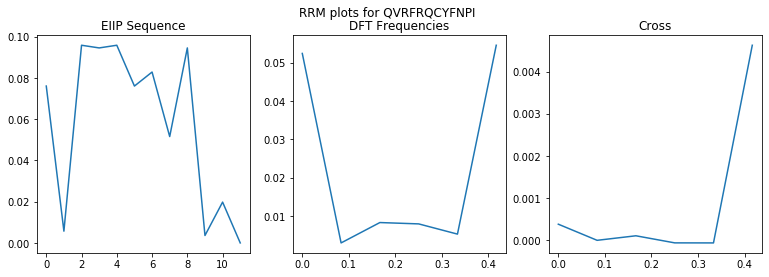

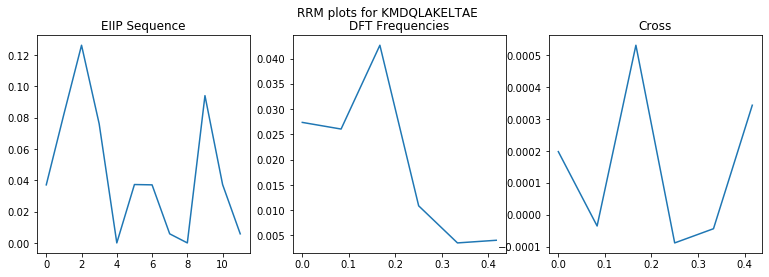

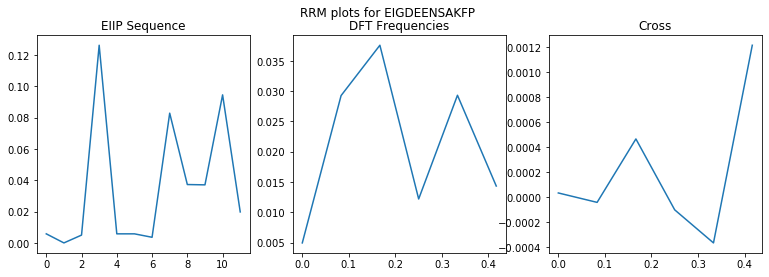

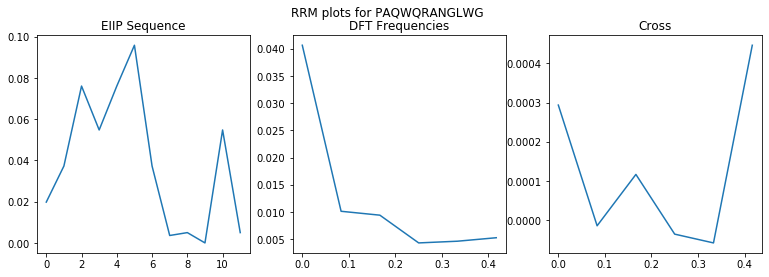

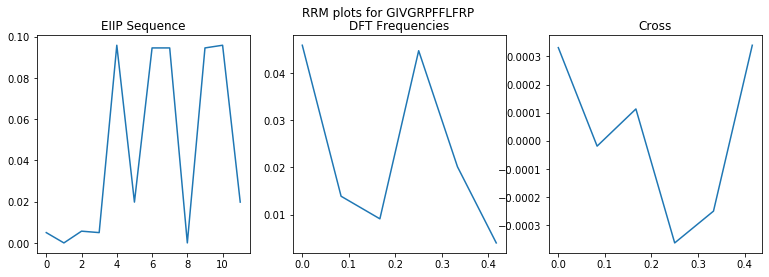

In [286]:
import matplotlib.pyplot as plt
i=100
#plt.plot(d1[0].rrm.freq[i], d1[0].rrm.dft[i])

for i in [100,300,600,800,1000]:
    plt.figure(figsize=(13,4))
    plt.subplot(131)
    plt.title('EIIP Sequence')
    plt.plot(d1[0].rrm.eiip[i])
    plt.subplot(132)
    plt.title('DFT Frequencies')
    plt.plot(d1[0].rrm.freq[i], d1[0].rrm.dft[i])
    plt.subplot(133)
    plt.title('Cross')
    plt.plot(d1[0].rrm.freq[i], d1[0].rrm.cross[i])
    plt.suptitle('RRM plots for ' + str(d1[0].rrm.seq[i]))
    plt.show()

## Figure generation
* To generate:
    * List of top sequences by RRM S/N
   

In [202]:
s
grbp5sn = d1[0].p.sort_values(by='RRM_SN', ascending=False)
m6sn = d1[0].p.sort_values(by='RRM_SN', ascending=False)
grbp5sn

,Sequences,PAM30,BLOSUM45,RRM_SN,RRM_Corr,weighted_matches,jaro_winkler,needleman_wunsch,smith_waterman,levenshtein,NUM_Seq,EIIP_Seq,FNS_Seq,sseq_matches
289,YLNQEQAEQGRE,-38,1,223.014349,0.118560,2,0.388889,0.541667,0.083333,0.083333,"[0, 1, 2, 2, 5, 2, 1, 5, 2, 4, 6, 5]","[0.0516, 0.0, 0.0036, 0.0761, 0.0058, 0.0761, ...","[Aromatic, Hydrophobic, Polar, Polar, Charge (...","[(E, 4)]"
516,QGMIGTLTSKRI,-56,-14,99.281091,0.125609,0,0.472222,0.500000,0.000000,0.083333,"[2, 4, 1, 1, 4, 2, 1, 2, 2, 6, 6, 1]","[0.0761, 0.005, 0.0823, 0.0, 0.005, 0.0941, 0....","[Polar, Glycine, Hydrophobic, Hydrophobic, Gly...",[]
435,APNQPSDNMIRF,-46,-4,34.342402,0.439926,2,0.444444,0.541667,0.083333,0.083333,"[1, 3, 2, 2, 3, 2, 5, 2, 1, 1, 6, 0]","[0.0373, 0.0198, 0.0036, 0.0761, 0.0198, 0.082...","[Hydrophobic, Proline, Polar, Polar, Proline, ...","[(S, 5)]"
1333,DHLPHDVYSPRL,-68,-15,34.176097,0.238400,0,0.388889,0.500000,0.083333,0.083333,"[5, 6, 1, 3, 6, 5, 1, 0, 2, 3, 6, 1]","[0.1263, 0.0242, 0.0, 0.0198, 0.0242, 0.1263, ...","[Charge (-), Charge (+), Hydrophobic, Proline,...",[]
1535,NTKKAVPGFYGT,-47,-13,30.873997,0.214782,0,0.388889,0.500000,0.000000,0.000000,"[2, 2, 6, 6, 1, 1, 3, 4, 0, 0, 4, 2]","[0.0036, 0.0941, 0.0371, 0.0371, 0.0373, 0.005...","[Polar, Polar, Charge (+), Charge (+), Hydroph...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,LAAQGLLYNAPK,-59,-13,0.000721,0.835440,0,0.388889,0.500000,0.000000,0.000000,"[1, 1, 1, 2, 4, 1, 1, 0, 2, 1, 3, 6]","[0.0, 0.0373, 0.0373, 0.0761, 0.005, 0.0, 0.0,...","[Hydrophobic, Hydrophobic, Hydrophobic, Polar,...",[]
929,ALAAQGLLYNAP,-31,3,0.000699,0.836269,2,0.388889,0.541667,0.083333,0.083333,"[1, 1, 1, 1, 2, 4, 1, 1, 0, 2, 1, 3]","[0.0373, 0.0, 0.0373, 0.0373, 0.0761, 0.005, 0...","[Hydrophobic, Hydrophobic, Hydrophobic, Hydrop...","[(Y, 8)]"
625,WTPQAMLYLKGT,-74,-17,0.000629,0.978517,0,0.388889,0.500000,0.000000,0.000000,"[0, 2, 3, 2, 1, 1, 1, 0, 1, 6, 4, 2]","[0.0548, 0.0941, 0.0198, 0.0761, 0.0373, 0.082...","[Aromatic, Polar, Proline, Polar, Hydrophobic,...",[]
1600,AGAEDVGLQPRL,-63,-13,0.000030,0.864084,0,0.388889,0.500000,0.000000,0.000000,"[1, 4, 1, 5, 5, 1, 4, 1, 2, 3, 6, 1]","[0.0373, 0.005, 0.0373, 0.0058, 0.1263, 0.0057...","[Hydrophobic, Glycine, Hydrophobic, Charge (-)...",[]


In [150]:

get_eiip_seq = lambda pep: list(map(lambda aa: AA_EIIP[aa], pep))
get_dft_from_eiip = lambda eiip: np.abs(np.fft.rfft(eiip)[1:])
get_dft_0100 = lambda dft: [np.interp(dft, (min(dft), max(dft)), (0,100))]
get_cross_spectrum = lambda p1, p2: [x1*x2 for x1, x2 in zip(np.abs(p1), np.conj(p2))]
#seq1 = list('PALPEDGGbSGAFPPGHFKDPKRLYCKNGGFFLRIHPDGRVDGVREKSDPHIKLQLQAEERGWSIKGVCANRYLAMKEDGRLLASKCVTDECFFFERLESNNYNTYRSRKYSSWYVALKRTGQYKLGPKTGPGQKAILFLPMSAKS')
#seq2 = list('FNLPLGNYKKPKLLYCSNGGYFLRILPDGTVDGTKDRSDQHIQLQLCAESIGEVYIKSTETGQFLAMDTDGLLYGSQTPNEECLFLERLEENHYNTYISKKHAEKHWFVGLKKNGRSKLGPRTHFGQKAILFLPLPVSSD')
seq3 = list('VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR') #alpha hemoglobin
seq4 = list('VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH') #beta hemoglobin
eiip1 = get_eiip_seq(seq3)
eiip2 = get_eiip_seq(seq4)
dft1 = get_dft_0100(get_dft_from_eiip(eiip1))
dft2 = get_dft_0100(get_dft_from_eiip(eiip2))
cross_spectrum = get_cross_spectrum(dft1, dft2)

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(131)
ax.plot(eiip1)
ax = fig.add_subplot(132)
ax.plot(eiip2)

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(131)
ax.plot(dft1)
ax = fig.add_subplot(132)
ax.plot(dft2)

fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(131)
ax.plot(cross_spectrum)

plt.show()

ValueError: operands could not be broadcast together with shapes (70,) (73,) 

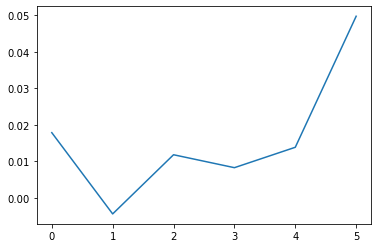

In [295]:
#seq1 = "VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYLLLLLL"
#seq2 = "VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
#seq1="FNLPLGNYKKPKLLYCSNGGYFLRILPDGTVDGTKDRSDQHIQLQLCAESIGEVYIKSTETGQFLAMDTDGLLYGSQTPNEECLFLERLEENHYNTYISKKHAEKHWFVGLKKNGRSKLGPRTHFGQKAILFLPLPVSSDLLLLLL"
#seq2="PALPEDGGSGAFPPGHFKDPKRLYCKNGGFFLRIHPDGRVDGVREKSDPHIKLQLQAEERGVVSIKGVCANRYLAMKEDGRLLASKCVTDECFFFERLESNNYNTYRSRKYSSWYVALKRTGQYKLGPKTGPGQKAILFLPMSAKS"
#seq1="IMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSYIMVTESSDYSSY"
#seq2="IMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDYIMVTASSAYDDY"
seq1="IMVTESSDYSSY"
seq2="IMVTASSAYDDY"
#add a command for maximum length sequences)

def RRM(seq):
    AA = list('LINGVEPHKAYWQMSCTFRD')
    EIIP = [0,0,0.0036,0.005,0.0057,0.0058,0.0198,0.0242,0.0371,0.0373,0.0516,0.0548,0.0761,0.0823,0.0829,0.0829,0.0941,0.0946,0.0959,0.1263]
    AA_EIIP = dict(zip(AA, EIIP))
    if (len(seq)%2) != 0.0:
        seq = seq + seq[:1]
    N = len(seq)
    x = []
    for s in range(N):
        x.append(AA_EIIP[seq[s]])
    m = np.reshape(np.linspace(1,int(N),int(N)),[1,int(N)])
    n = np.reshape(np.linspace(1,int(N/2),int(N/2)),[1,int(N/2)])
    v = np.matmul(np.transpose(m), n)
    cx = np.cos(2*np.pi/N*v)
    sx = np.sin(2*np.pi/N*v)
    Xre = np.reshape(np.matmul(x,cx),[1,int(N/2)])
    Xim = np.reshape(np.matmul(x,sx),[1,int(N/2)])
    A = np.reshape(np.sqrt(Xre**2 + Xim**2),[1,int(N/2)])
    phase = np.reshape(np.arctan(Xim/Xre),[1,int(N/2)])
    scaled = 100*(A-min(min(A)))/(max(max(A))-min(min(A)))
    return n, N, Xre, Xim, A, phase, m, x, scaled
	


result11 = RRM(seq1)

result2 = RRM(seq2)

S = result11[2]*result2[2]+result11[3]*result2[3]
plt.plot(S[0])

In [292]:
result11

(array([[1., 2., 3., 4., 5., 6.]]),
 12,
 array([[-0.06392295, -0.0298    ,  0.0239    , -0.0868    , -0.05387705,
          0.2912    ]]),
 array([[-1.54305633e-01,  2.23434554e-02, -1.14100000e-01,
         -3.23893501e-02, -9.74943668e-02,  1.06239243e-17]]),
 array([[0.16702207, 0.03724607, 0.11657624, 0.09264615, 0.1113907 ,
         0.2912    ]]),
 array([[ 1.17805597e+00, -6.43360539e-01, -1.36431623e+00,
          3.57147060e-01,  1.06594606e+00,  3.64832565e-17]]),
 array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]]),
 [0,
  0.0823,
  0.0057,
  0.0941,
  0.0058,
  0.0829,
  0.0829,
  0.1263,
  0.0516,
  0.0829,
  0.0829,
  0.0516],
 array([[ 51.10218124,   0.        ,  31.23801575,  21.81501266,
          29.19609427, 100.        ]]))

# Initial Toying Around (pre Feb 22)

,Sequences,PAM30,BLOSUM45,RRM_SN,RRM_Corr,weighted_matches,jaro_winkler,needleman_wunsch,smith_waterman,levenshtein,NUM_Seq,EIIP_Seq,FNS_Seq,sseq_matches
271,SKDQLSEDASKV,-34,1,-29.309751-2.481899j,-0.196732,6,0.544444,0.625000,0.250000,0.250000,"[2, 6, 5, 2, 1, 2, 5, 5, 1, 2, 6, 1]","[0.0829, 0.0371, 0.1263, 0.0761, 0.0, 0.0829, ...","[Polar, Charge (+), Charge (-), Polar, Hydroph...","[(S, 5), (D, 7), (S, 9)]"
270,ESKDQLSEDASK,-37,-1,-28.871790-2.420084j,-0.196310,4,0.544444,0.583333,0.166667,0.166667,"[5, 2, 6, 5, 2, 1, 2, 5, 5, 1, 2, 6]","[0.0058, 0.0829, 0.0371, 0.1263, 0.0761, 0.0, ...","[Charge (-), Polar, Charge (+), Charge (-), Po...","[(S, 6), (S, 10)]"
1535,NTKKAVPGFYGT,-47,-13,-27.589317+13.857607j,-0.214782,0,0.388889,0.500000,0.000000,0.000000,"[2, 2, 6, 6, 1, 1, 3, 4, 0, 0, 4, 2]","[0.0036, 0.0941, 0.0371, 0.0371, 0.0373, 0.005...","[Polar, Polar, Charge (+), Charge (+), Hydroph...",[]
1467,SANSNPALAPRE,-57,-15,-24.770251+7.989317j,-0.127477,0,0.444444,0.500000,0.000000,0.000000,"[2, 1, 2, 2, 2, 3, 1, 1, 1, 3, 6, 5]","[0.0829, 0.0373, 0.0036, 0.0829, 0.0036, 0.019...","[Polar, Hydrophobic, Polar, Polar, Polar, Prol...",[]
942,VVSVVPGAISHA,-35,-3,-13.635302+7.322366j,-0.308027,2,0.500000,0.541667,0.083333,0.083333,"[1, 1, 2, 1, 1, 3, 4, 1, 1, 2, 6, 1]","[0.0057, 0.0057, 0.0829, 0.0057, 0.0057, 0.019...","[Hydrophobic, Hydrophobic, Polar, Hydrophobic,...","[(S, 9)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,DITSGMWFGPRL,-66,-16,22.268754+7.320871j,-0.184736,0,0.472222,0.500000,0.000000,0.000000,"[5, 1, 2, 2, 4, 1, 0, 0, 4, 3, 6, 1]","[0.1263, 0.0, 0.0941, 0.0829, 0.005, 0.0823, 0...","[Charge (-), Hydrophobic, Polar, Polar, Glycin...",[]
1333,DHLPHDVYSPRL,-68,-15,25.249466+23.031936j,-0.238400,0,0.388889,0.500000,0.083333,0.083333,"[5, 6, 1, 3, 6, 5, 1, 0, 2, 3, 6, 1]","[0.1263, 0.0242, 0.0, 0.0198, 0.0242, 0.1263, ...","[Charge (-), Charge (+), Hydrophobic, Proline,...",[]
676,PVYIPQPRPPHP,-74,-16,25.541059+16.417084j,-0.243879,0,0.277778,0.500000,0.000000,0.000000,"[3, 1, 0, 1, 3, 2, 3, 6, 3, 3, 6, 3]","[0.0198, 0.0057, 0.0516, 0.0, 0.0198, 0.0761, ...","[Proline, Hydrophobic, Aromatic, Hydrophobic, ...",[]
289,YLNQEQAEQGRE,-38,1,42.952638-218.838915j,-0.118560,2,0.388889,0.541667,0.083333,0.083333,"[0, 1, 2, 2, 5, 2, 1, 5, 2, 4, 6, 5]","[0.0516, 0.0, 0.0036, 0.0761, 0.0058, 0.0761, ...","[Aromatic, Hydrophobic, Polar, Polar, Charge (...","[(E, 4)]"


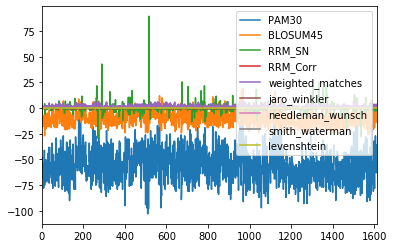

In [186]:
rex = d1[0].rrm
d1d[0].plot()
both = pd.concat([d1d[0], d1d[1]])
d1[0].p.sort_values(by='RRM_SN')

In [332]:
rex.iloc[2].dft

array([0.01647958, 0.02696152, 0.02712326, 0.00603055, 0.01867408,
       0.00361667])

In [397]:
maxes = [signal.find_peaks(abs(rex['cross'].iloc[n])) for n in range(len(rex))]
maxheight = [np.abs(rex['cross'].iloc[i][m[0]]) for i, m in enumerate(maxes)]
maxes[:10], maxheight[:10]

([(array([3]), {}),
  (array([3]), {}),
  (array([3, 5]), {}),
  (array([3]), {}),
  (array([3]), {}),
  (array([3]), {}),
  (array([3, 5]), {}),
  (array([3]), {}),
  (array([3]), {}),
  (array([3]), {})],
 [array([0.00957542]),
  array([0.01032822]),
  array([0.01897157, 0.01248071]),
  array([0.01106283]),
  array([0.00957542]),
  array([0.01032822]),
  array([0.01979546, 0.01312217]),
  array([0.01242281]),
  array([0.00957542]),
  array([0.01032822])])

In [392]:
import seaborn as sns




maxheight = [np.abs(rex['cross'].iloc[i][m[0]]) for i, m in enumerate(maxes)]
print(np.ravel([*maxheight])[:5])
maxval = np.amax(np.ravel(maxheight))
maxind = np.argmax(maxheight)
maxinds = sorted(maxheight, reverse=True)
top_idx = np.argsort(maxheight)[-10:]
top_values = [maxheight[i] for i in top_idx]
top_seq = []
for i in top_idx:
    top_seq.append(rex['seq'].iloc[i])
    #print(rex['seq'].iloc[i], top_values)
print(rex.seq, top_seq)
i = maxind
sns.relplot(x="freq", y="dft", kind="line", data=rex.iloc[i])

IndexError: invalid index to scalar variable.

Text(0.5, 1.0, 'GCRFGTCTVQKL, freq')

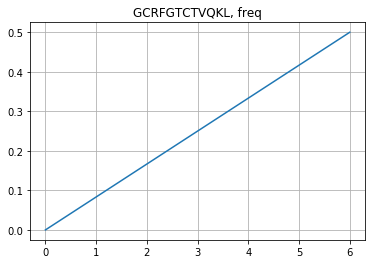

In [259]:
col = 4
seq = 14
plt.plot(rex.iloc[seq, col])
plt.grid()
plt.title(rex.iloc[seq, 0]+", "+str(rex.columns[col]))

Text(0.5, 1.0, 'KVAFSAIRSTNH: dft')

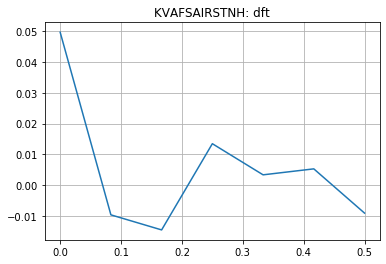

In [270]:
seq=400
plt.plot(rex.iloc[seq, 4], rex.iloc[seq, 2])
plt.grid()
plt.title(rex.iloc[seq,0]+": "+str(rex.columns[2]))

In [206]:
out = d1[0].p[d1[0].p['Sequences'].isin(top_seq)]
#out =out['Sequences'].drop_duplicates()
out.head()

,Sequences,PAM30,BLOSUM45,RRM_SN,RRM_Corr,weighted_matches,jaro_winkler,needleman_wunsch,smith_waterman,levenshtein,NUM_Seq,EIIP_Seq,FNS_Seq
474,FPDFYDSGEHLS,-65,NaN,NaN,NaN,2,0.477778,0.541667,0.083333,0.083333,"[0, 3, 5, 0, 0, 5, 2, 4, 5, 6, 1, 2]","[0.0946, 0.0198, 0.1263, 0.0946, 0.0516, 0.126...",-13
1103,LDGLDGSGFGFD,-38,NaN,NaN,NaN,2,0.277778,0.541667,0.083333,0.083333,"[1, 5, 4, 1, 5, 4, 2, 4, 0, 4, 0, 5]","[0.0, 0.1263, 0.005, 0.0, 0.1263, 0.005, 0.082...",-2
1507,MRQYLVLSMQSS,-62,NaN,NaN,NaN,2,0.611111,0.541667,0.166667,0.166667,"[1, 6, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2]","[0.0823, 0.0959, 0.0761, 0.0516, 0.0, 0.0057, ...",-10
1539,MRQYLVLSMQSS,-62,NaN,NaN,NaN,2,0.611111,0.541667,0.166667,0.166667,"[1, 6, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2]","[0.0823, 0.0959, 0.0761, 0.0516, 0.0, 0.0057, ...",-10
1561,MRQYLVLSMQSS,-62,NaN,NaN,NaN,2,0.611111,0.541667,0.166667,0.166667,"[1, 6, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2]","[0.0823, 0.0959, 0.0761, 0.0516, 0.0, 0.0057, ...",-10


In [174]:
print(d1[0].p.describe())
print(d1[0].p[d1[0].p['Sequences'].isin(top_seq)].describe())

       weighted_matches  jaro_winkler  needleman_wunsch  smith_waterman  \
count       3078.000000   3078.000000       3078.000000     3078.000000   
mean           1.139701      0.419312          0.526492        0.064138   
std            1.350734      0.107040          0.032280        0.066640   
min            0.000000      0.000000          0.500000        0.000000   
25%            0.000000      0.388889          0.500000        0.000000   
50%            0.000000      0.444444          0.500000        0.083333   
75%            2.000000      0.477778          0.541667        0.083333   
max            7.000000      0.674603          0.666667        0.333333   

       levenshtein  
count  3078.000000  
mean      0.066629  
std       0.067072  
min       0.000000  
25%       0.000000  
50%       0.083333  
75%       0.083333  
max       0.333333  
       weighted_matches  jaro_winkler  needleman_wunsch  smith_waterman  \
count         15.000000     15.000000         15.000000     

In [168]:
top_seq[0]

'MRQYLVLSMQSS'

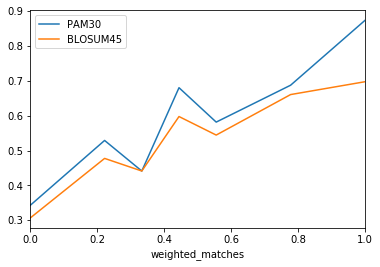

In [328]:
d1[2].pdata.groupby('weighted_matches').mean().plot()

In [ ]:
self.bsseq.sort(key = lambda ss: len(ss[0]), reverse=True)
        score: float = lambda s: (single_match_weight * 1) + (len(s)**weight)
        matches: List = list(); nmatches = list()
        for i, seq in enumerate(self.p_ls):
            matches.append(list()); nmatches.append(int())
            iter_skip = 0
            for j in range(len(seq)):
                if iter_skip > 0:
                    iter_skip -= 1
                    continue
                for (sseq, bin_i) in self.bsseq:
                    in_seq = inseq
                    if (bin_i == j) and (in_seq == sseq):
                        matches[i].append((sseq, bin_i))
                        nmatches[i] += score(sseq)
                        iter_skip += len(sseq)
                        continue
        self.p.sseq_matches, self.p.weighted_matches = matches, nmatches

In [209]:
merge = rex.merge(d1[0].p, left_on=rex.index, right_on=d1[0].p.index)

corr = [sum([merge.iloc[i].power for m in row]) for i, row in enumerate(merge)]
print(corr[0], len(corr), len(merge))
corr = [np.interp(corr[i], (min(corr[i]), max(corr[i])), (0,1)) for i in range(len(merge))]
ds = []; c = []
for dist in list(d['dist'].keys()):
    distances = [np.interp(merge[dist].iloc[i], (merge[dist].iloc[i].min(), merge[dist].iloc[i].max()), (0,1))]
    ds.append(distances)
    c.apppend(np.corrcoef(corr, distances))[1,2]
merge.plot(corr, ds[0])


[1.96198920e-02 9.92613199e-04 7.33654514e-04 2.34262847e-04
 3.80461806e-05 6.87574995e-04 5.57501701e-03] 25 3078


IndexError: list index out of range

In [205]:
merge

,key_0,seq,eiip,dft,dft2,freq,power,peak_loc,peak_val,peak_dist,...,RRM_SN,RRM_Corr,weighted_matches,jaro_winkler,needleman_wunsch,smith_waterman,levenshtein,NUM_Seq,EIIP_Seq,FNS_Seq
0,0,SVPHFSDEDKDP,"[0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...","[(0.06264166666666665+0j), (-0.011294400459931...","[0.1252833333333333, 0.028179612473691253, 0.0...","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.003923978402777776, 0.0001985226397918539, ...",[],{},[],...,NaN,NaN,2,0.477778,0.541667,0.166667,0.166667,"[2, 1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 3]","[0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...",-8
1,1,VPHFSDEDKDPE,"[0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.126...","[(0.056216666666666665+0j), (-0.01955731388825...","[0.11243333333333333, 0.039239587699259636, 0....","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.003160313611111111, 0.000384936310701972, 0...",[],{},[],...,NaN,NaN,2,0.472222,0.541667,0.083333,0.083333,"[1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 3, 5]","[0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.126...",-3
2,2,SVPHFSEEEKEA,"[0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...","[(0.033975+0j), (1.021992058759744e-05-0.00823...","[0.06795, 0.016479581260746716, 0.026961520934...","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.001154300625, 6.789414963238858e-05, 0.0001...","[3, 5]",{},"[0, 2]",...,NaN,NaN,2,0.472222,0.541667,0.083333,0.083333,"[2, 1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 1]","[0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...",-6
3,3,VPHFSEEEKEAE,"[0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.005...","[(0.027549999999999998+0j), (-0.00143547036225...","[0.055099999999999996, 0.020884774229360296, 0...","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.0007590024999999999, 0.00010904344865283799...","[2, 5]",{},"[1, 2]",...,NaN,NaN,0,0.388889,0.500000,0.000000,0.000000,"[1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 1, 5]","[0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.005...",-5
4,4,SVPHFSDEDKDP,"[0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...","[(0.06264166666666665+0j), (-0.011294400459931...","[0.1252833333333333, 0.028179612473691253, 0.0...","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.003923978402777776, 0.0001985226397918539, ...",[],{},[],...,NaN,NaN,2,0.477778,0.541667,0.166667,0.166667,"[2, 1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 3]","[0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...",-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,3073,FLRRIRPKLKWD,"[0.0946, 0.0, 0.0959, 0.0959, 0.0, 0.0959, 0.0...","[(0.05478333333333333+0j), (0.0120289691495536...","[0.10956666666666666, 0.026094853577604493, 0....","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.003001213611111111, 0.0001702353458091545, ...",[4],{},[1],...,NaN,NaN,0,0.444444,0.500000,0.000000,0.000000,"[0, 1, 6, 6, 1, 6, 3, 6, 1, 6, 0, 5]","[0.0946, 0.0, 0.0959, 0.0959, 0.0, 0.0959, 0.0...",-15
3074,3074,LRRIRPKLKWDN,"[0.0, 0.0959, 0.0959, 0.0, 0.0959, 0.0198, 0.0...","[(0.0472+0j), (0.006376852056801644-0.00215376...","[0.0944, 0.01346148948945863, 0.02273646728153...","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.00222784, 4.530292481870129e-05, 0.00012923...",[3],{},[0],...,NaN,NaN,0,0.444444,0.500000,0.000000,0.000000,"[1, 6, 6, 1, 6, 3, 6, 1, 6, 0, 5, 2]","[0.0, 0.0959, 0.0959, 0.0, 0.0959, 0.0198, 0.0...",-15
3075,3075,RRIRPKLKWDNQ,"[0.0959, 0.0959, 0.0, 0.0959, 0.0198, 0.0371, ...","[(0.05354166666666666+0j), (0.0120914403741765...","[0.10708333333333332, 0.025799178373241267, 0....","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.002866710069444444, 0.00016639940118357997,...",[3],{},[0],...,NaN,NaN,0,0.444444,0.500000,0.000000,0.000000,"[6, 6, 1, 6, 3, 6, 1, 6, 0, 5, 2, 2]","[0.0959, 0.0959, 0.0, 0.0959, 0.0198, 0.0371, ...",-4
3076,3076,YGGFLRRQFKVV,"[0.0516, 0.005, 0.005, 0.0946, 0.0, 0.0959, 0....","[(0.047266666666666665+0j), (-0.01882832480253...","[0.09453333333333333, 0.037744954227810754, 0....","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.0022

In [287]:
d1[0].p.to_csv('./out/v4/grbp5_pdata.csv')
d1[1].p.to_csv('./out/v4/m6_pdata.csv')
d1[0].p_match.to_csv('./out/v4/grbp5_pmatch.csv')
d1[1].p_match.to_csv('./out/v4/m6_pmatch.csv')
d1[0].p_match.describe().to_csv('./out/v4/grbp5_pmatch_summary.csv')
d1[1].p_match.describe().to_csv('./out/v4/m6_pmatch_summary.csv')
d1[0].p.describe().to_csv('./out/v4/grbp5_pdata_summary.csv')
d1[1].p.describe().to_csv('./out/v4/m6_pdata_summary.csv')
d1[0].rrm.to_csv('./out/v4/grbp5_rrm.csv')
d1[1].rrm.to_csv('./out/v4/m6_rrm.csv')
d1[0].rrm.describe().to_csv('./out/v4/grbp5_rrm_summary.csv')
d1[1].rrm.describe().to_csv('./out/v4/m6_rrm_summary.csv')